<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-study-1.1.2:-LDA-analysis" data-toc-modified-id="Case-study-1.1.2:-LDA-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case study 1.1.2: LDA analysis</a></span></li><li><span><a href="#Database-generation-(Web-Scraping)" data-toc-modified-id="Database-generation-(Web-Scraping)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Database generation (Web Scraping)</a></span><ul class="toc-item"><li><span><a href="#Obtaining-the-vocabulary" data-toc-modified-id="Obtaining-the-vocabulary-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Obtaining the vocabulary</a></span></li></ul></li><li><span><a href="#LDA-SVI" data-toc-modified-id="LDA-SVI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LDA-SVI</a></span><ul class="toc-item"><li><span><a href="#Auxiliary-functions" data-toc-modified-id="Auxiliary-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Auxiliary functions</a></span><ul class="toc-item"><li><span><a href="#File-handling" data-toc-modified-id="File-handling-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>File handling</a></span></li><li><span><a href="#Feature-generation-(word-counting)" data-toc-modified-id="Feature-generation-(word-counting)-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Feature generation (word counting)</a></span></li><li><span><a href="#Probability-distributions-calculations" data-toc-modified-id="Probability-distributions-calculations-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Probability distributions calculations</a></span></li></ul></li><li><span><a href="#LDA-implementation-trough-SVI" data-toc-modified-id="LDA-implementation-trough-SVI-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LDA implementation trough SVI</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Aditional-tasks" data-toc-modified-id="Aditional-tasks-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Aditional tasks</a></span></li></ul></div>

# Case study 1.1.2: LDA analysis

Notebook setup:

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import csv

from scipy.special import psi

#Web scraping libraries
from bs4 import BeautifulSoup

from tqdm.notebook import tqdm

#NLP libraries
import nltk
#run the first time you install nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize


# Database generation (Web Scraping)

First of all, we need to obtain the list of EECS faculty, and the lab they belong to. In order to achieve this we can use _web scraping_ libraries like `BeautifulSoup`. This kind of libraries offer different functions for exploring the source code of websites, and allow an easy way of retrieving information from them.

In [2]:
#Url of EECS faculty list
url_eecs_fac = 'https://www.eecs.mit.edu/people/faculty-advisors'
#Downloading the source code
html_data = requests.get(url_eecs_fac).text
soup = BeautifulSoup(html_data, 'html.parser')
#Storing the name and lab in two lists
fac = [el.text for el in soup.find_all(class_ = 'field-content card-title')]
labs = []
for lab_raw in soup.find_all(class_ = 'views-field views-field-term-node-tid'):
    try:
        labs.append(lab_raw.find('a').text)
    except:
        labs.append('')
#Joining both lists and deleting professors that do not belong to CSAIL, MTL, RLE or LIDS
fac_dept = list(zip(fac,labs))
fac_dept = [tup for tup in fac_dept if tup[1] in set(['CSAIL','MTL','RLE','LIDS'])]

print('Number of EECS faculty: {}'.format(len(fac_dept)))
print(fac_dept[:5],'...')

Number of EECS faculty: 165
[('Hal Abelson', 'CSAIL'), ('Elfar Adalsteinsson', 'RLE'), ('Anant Agarwal', 'CSAIL'), ('Pulkit Agrawal', 'CSAIL'), ('Akintunde Akinwande', 'MTL')] ...


The guide of the case study suggests working with `.txt` files in a certain directory. Therefore we can create such directory (`Data`), where we'll be able to store all the abstracts of the articles of interest. In such folder, we create a file named `alldocs.txt`, where all the paths leading to the `.txt` files will be written.

In [3]:
#Creating list of all docs ('alldocs.txt') in the desired directory
DATA_DIRECTORY = 'Data/'

with open(r"{}{}.txt".format(DATA_DIRECTORY,'alldocs'), "w") as f:
    pass    

A function for obtaining all the _arXiv_ articles for a certain author can be defined. We can also define a function that stores their abstracts in `.txt`files.

In [4]:
def save_abstract_to_txt(filename,content,directory=DATA_DIRECTORY):
    '''
    Creates a new .txt file and writing the abstract in it.
    Saves the title as a new line in the alldocs.txt file
    '''
    with open(r"{}{}.txt".format(directory,filename), "w") as f:
        print(content, file=f)
        
    with open(r"{}{}.txt".format(directory,'alldocs'), "a") as alldocs:
        alldocs.write(filename+'.txt\n')
        
def get_articles_for_author(author,save_abstracts = False):
    base_url = 'https://arxiv.org/search/?query=%22{name}%22&searchtype=author&abstracts=show&order=-announced_date_first&size=200'
    author_query_url = base_url.format(name= author.replace(' ','+'))
    query_result = requests.get(author_query_url).text
    soup = BeautifulSoup(query_result, 'html.parser')
    articles = soup.find_all(class_ = 'arxiv-result')
    #print('{} articles found for author = \"{}\"\n'.format(len(articles),author))

    #print('Parsing information from html arXiv source code: id, title, authors and abstract\n')
    ids = [el.find(class_ = 'list-title is-inline-block').find('a').text.strip('arXiv:') for el in articles]
    ids = [el.split('/')[1] if el.find('/')>=0 else el for el in ids]
    
    titles = [el.find(class_ = 'title is-5 mathjax').text.strip(' \n') for el in articles]
    authors = [[author.text for author in el.find(class_ = 'authors').find_all('a')] for el in articles]
    abstracts = [el.find(class_ = 'abstract-full has-text-grey-dark mathjax').text[9:-16] for el in articles]
    urls = [el.find(class_ = 'list-title is-inline-block').find('a')['href'] for el in articles]
    
    #Saving abstracts
    if save_abstracts:
        for i in range(len(articles)):
            save_abstract_to_txt(ids[i], abstracts[i])
    
    return ids, titles, authors, urls, abstracts

author = fac_dept[23][0]
print('Example of an article by {}: \n'.format(author))
ids, titles, authors, urls, abstracts = get_articles_for_author(author)
i = 0
print('arXiv ID: {} (url: {} )'.format(ids[i],urls[i]))
print('Title: {}'.format(titles[i]))
print('Authors: {}'.format(authors[i]))
print('---\n{}\n---'.format(abstracts[i]))

Example of an article by Tamara Broderick: 

arXiv ID: 1912.05516 (url: https://arxiv.org/abs/1912.05516 )
Title: More for less: Predicting and maximizing genetic variant discovery via Bayesian nonparametrics
Authors: ['Lorenzo Masoero', 'Federico Camerlenghi', 'Stefano Favaro', 'Tamara Broderick']
---
While the cost of sequencing genomes has decreased dramatically in recent years, this expense often remains non-trivial. Under a fixed budget, then, scientists face a natural trade-off between quantity and quality; they can spend resources to sequence a greater number of genomes (quantity) or spend resources to sequence genomes with increased accuracy (quality). Our goal is to find the optimal allocation of resources between quantity and quality. Optimizing resource allocation promises to reveal as many new variations in the genome as possible, and thus as many new scientific insights as possible. In this paper, we consider the common setting where scientists have already conducted a pil

Once we have such function defined, and we've checked it works, we can iterate through the list of professors to obtain all the arXiv articles, and store them in `.txt` files.

In [5]:
ids = []
titles = []
authors = []
labs = []
EECS_facs = []
urls = []
abstracts = []
print('Downloading articles of each professor:')
t0 = time.time()
for i,fac in enumerate(fac_dept):
    id_list, title_list, author_list, url_list, abstract_list  = get_articles_for_author(fac[0],save_abstracts= True)
    ids += id_list
    titles += title_list
    authors += author_list
    urls += url_list
    abstracts += abstract_list
    labs += [fac[1]]*len(id_list)
    EECS_facs += [fac[0]]*len(id_list)
    if round(i/10) == i/10:
        print('{}/{} authors'.format(i,len(fac_dept)))
tf = time.time()
print('{} articles downloaded in {:.2f}s'.format(len(ids),tf-t0))

0/165 authors
10/165 authors
20/165 authors
30/165 authors
40/165 authors
50/165 authors
60/165 authors
70/165 authors
80/165 authors
90/165 authors
100/165 authors
110/165 authors
120/165 authors
130/165 authors
140/165 authors
150/165 authors
160/165 authors
2614 articles downloaded in 55.37s


If instead of working with different `.txt` files, we would like to store all the information in a `pandas` data frame, the next ecll shows how to do so:

In [6]:
df = pd.DataFrame({'id':ids,'title':titles,'EECS_prof':EECS_facs,'lab':labs,'authors':authors,'url':urls,'abstract':abstracts})
df[['id','lab']] = df[['id','lab']].drop_duplicates()
df.head()

,id,title,EECS_prof,lab,authors,url,abstract
0,1910.03273,Joint multi-contrast Variational Network recon...,Elfar Adalsteinsson,RLE,"[Daniel Polak, Stephen Cauley, Berkin Bilgic, ...",https://arxiv.org/abs/1910.03273,Purpose: To improve the image quality of highl...
1,1909.13692,Nonlinear Dipole Inversion (NDI) enables Quant...,Elfar Adalsteinsson,RLE,"[Daniel Polak, Itthi Chatnuntawech, Jaeyeon Yo...",https://arxiv.org/abs/1909.13692,We propose Nonlinear Dipole Inversion (NDI) fo...
2,1907.04500,Fetal Pose Estimation in Volumetric MRI using ...,Elfar Adalsteinsson,RLE,"[Junshen Xu, Molin Zhang, Esra Abaci Turk, Lar...",https://arxiv.org/abs/1907.04500,The performance and diagnostic utility of magn...
3,1903.02959,Temporal Registration in Application to In-ute...,Elfar Adalsteinsson,RLE,"[Ruizhi Liao, Esra A. Turk, Miaomiao Zhang, Ji...",https://arxiv.org/abs/1903.02959,We present a robust method to correct for moti...
4,1608.03907,Temporal Registration in In-Utero Volumetric M...,Elfar Adalsteinsson,RLE,"[Ruizhi Liao, Esra Turk, Miaomiao Zhang, Jie L...",https://arxiv.org/abs/1608.03907,We present a robust method to correct for moti...


## Obtaining the vocabulary

In order to use LDA, we need a `.csv` file with the vocabulary. We can obtain it from the original LDA SVI repository by blei-lab: 
* https://raw.githubusercontent.com/blei-lab/onlineldavb/master/dictnostops.txt

In [7]:
url = 'https://raw.githubusercontent.com/blei-lab/onlineldavb/master/dictnostops.txt'
vocab = pd.Series(requests.get(url).text.split('\n')[:-1])
vocab.to_csv('Data/dictionary.csv',header=False,index=False)

# LDA-SVI

## Auxiliary functions

### File handling

In [8]:
def get_filenames(filename):
    filenames = []
    with open(r"{}{}".format(DATA_DIRECTORY,filename), 'r') as f:
        docs = f.readlines()
        for doc in docs:
            filenames.append(str(doc).split("\n")[0])
    return filenames

def getfiles(filename):
    f = open(r"{}{}".format(DATA_DIRECTORY,filename), 'r')
    doc = f.read().split('\n')[0]
    return doc

def getalldocs(filename = None):
    files = get_filenames(filename)
    docs = []
    for file in files:
        doc = getfiles(file)
        docs.append(doc)
    return docs

def getVocab(file):
    '''getting vocab dictionary from a csv file (nostopwords)'''
    vocab = dict()
    with open(r"{}{}".format(DATA_DIRECTORY,file), 'r') as infile:
        reader = csv.reader(infile)
        for index, row in enumerate(reader):
            vocab[row[0]] = index

    return vocab

### Feature generation (word counting)

In [9]:
def parseDocument(doc, vocab):
    wordslist = list()
    countslist = list()
    doc = doc.lower()
    tokens = wordpunct_tokenize(doc)

    dictionary = dict()
    for word in tokens:
        if word in vocab:
            wordtk = vocab[word]
            if wordtk not in dictionary:
                dictionary[wordtk] = 1
            else:
                dictionary[wordtk] += 1

    wordslist.append(list(dictionary.keys()))
    countslist.append(list(dictionary.values()))
    return (wordslist[0], countslist[0])

### Probability distributions calculations

In [10]:
def dirichlet_expectation(alpha):
    '''
    For a vector theta ~ Dir(alpha), computes E[log(theta)] given alpha.
    
    Taken from https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py
    '''
    if (len(alpha.shape) == 1):
        return (psi(alpha) - psi(n.sum(alpha)))
    return (psi(alpha) - psi(n.sum(alpha, 1))[:, n.newaxis])

def beta_expectation(a, b, k):
    mysum = psi(a + b)
    Elog_a = psi(a) - mysum
    Elog_b = psi(b) - mysum
    Elog_beta = n.zeros(k)
    Elog_beta[0] = Elog_a[0]
    # print Elog_beta
    for i in range(1, k):
        Elog_beta[i] = Elog_a[i] + n.sum(Elog_b[0:i])
        # print Elog_beta
    # print Elog_beta
    return Elog_beta

def plottrace(x, Y, K, n, perp):
    for i in range(K):
        plt.plot(x, Y[i], label = "Topic %i" %(i+1))

    plt.xlabel("Number of Iterations")
    plt.ylabel("Probability of Each topic")
    plt.legend()
    plt.title("Trace plot for topic probabilities")
    plt.savefig("temp/plot_%i_%i_%f.png" %(K, n, perp))

## LDA implementation trough SVI

We can obtain the LDA implementation through SVI from:
* https://github.com/qlai/stochasticLDA
* https://github.com/blei-lab/onlineldavb

In [16]:
import sys, re, time, string, random, csv, argparse
import numpy as n
from scipy.special import psi
from nltk.tokenize import wordpunct_tokenize
#from utils import *
# import matplotlib.pyplot as plt

n.random.seed(10000001)
meanchangethresh = 1e-3
MAXITER = 10000

class SVILDA():
    """
        Arguments:
        K: Number of topics
        vocab: A set of words to recognize. When analyzing documents, any word
           not in this set will be ignored.
        D: Total number of documents in the population. For a fixed corpus,
           this is the size of the corpus. In the truly online setting, this
           can be an estimate of the maximum number of documents that
           could ever be seen.
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        tau: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.
        Note that if you pass the same set of D documents in every time and
        set kappa=0 this class can also be used to do batch VB.
    """
        
    def __init__(self, vocab, K, D, alpha, eta, tau, kappa, docs, iterations, parsed = False):
        self._vocab = vocab
        self._V = len(vocab)
        self._K = K
        self._D = D
        self._alpha = alpha
        self._eta = eta
        self._tau = tau
        self._kappa = kappa
        self._lambda = 1* n.random.gamma(100., 1./100., (self._K, self._V))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)
        self._docs = docs
        self.ct = 0
        self._iterations = iterations
        self._parsed = parsed
        self._trace_lambda = {}
        for i in range(self._K):
            self._trace_lambda[i] = [self.computeProbabilities()[i]]
        self._x = [0]

    def updateLocal(self, doc): #word_dn is an indicator variable with dimension V
        (words, counts) = doc
        newdoc = []
        N_d = sum(counts)
        phi_d = n.zeros((self._K, N_d))
        gamma_d = n.random.gamma(100., 1./100., (self._K))
        Elogtheta_d = dirichlet_expectation(gamma_d)
        expElogtheta_d = n.exp(Elogtheta_d)
        for i, item in enumerate(counts):
            for j in range(item):
                newdoc.append(words[i])
        assert len(newdoc) == N_d, "error"

        for i in range(self._iterations):
            for m, word in enumerate(newdoc):
                phi_d[:, m] = n.multiply(expElogtheta_d, self._expElogbeta[:, word]) + 1e-100
                phi_d[:, m] = phi_d[:, m]/n.sum(phi_d[:, m])

            gamma_new = self._alpha + n.sum(phi_d, axis = 1)
            meanchange = n.mean(abs(gamma_d - gamma_new))
            if (meanchange < meanchangethresh):
                break

            gamma_d = gamma_new
            Elogtheta_d = dirichlet_expectation(gamma_d)
            expElogtheta_d = n.exp(Elogtheta_d)

        newdoc = n.asarray(newdoc)
        return phi_d, newdoc, gamma_d

    def updateGlobal(self, phi_d, doc):

        lambda_d = n.zeros((self._K, self._V))

        for k in range(self._K):
            phi_dk = n.zeros(self._V)
            for m, word in enumerate(doc):
                phi_dk[word] += phi_d[k][m] 
            lambda_d[k] = self._eta + self._D * phi_dk
        rho = (self.ct + self._tau) **(-self._kappa)
        self._lambda = (1-rho) * self._lambda + rho * lambda_d
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)

        if self.ct % 10 == 9:
            for i in range(self._K):
                self._trace_lambda[i].append(self.computeProbabilities()[i])
            self._x.append(self.ct)

    def runSVI(self):
        for i in tqdm(range(self._iterations)):
            randint = random.randint(0, self._D-1)
            #print("ITERATION", i, " running document number ", randint)
            if self._parsed == False:
                doc = parseDocument(self._docs[randint],self._vocab)
            phi_doc, newdoc, gamma_d = self.updateLocal(doc)
            self.updateGlobal(phi_doc, newdoc)
            self.ct += 1
                
    def computeProbabilities(self):
        prob_topics = n.sum(self._lambda, axis = 1)
        prob_topics = prob_topics/n.sum(prob_topics)
        return prob_topics

    def getTopics(self, docs = None):
        prob_topics = self.computeProbabilities()
        prob_words = n.sum(self._lambda, axis = 0)

        if docs == None:
            docs = self._docs
        results = n.zeros((len(docs), self._K))
        for i, doc in enumerate(docs):
            parseddoc = parseDocument(doc, self._vocab)

            for j in range(self._K):
                aux = [self._lambda[j][word]/prob_words[word] for word in parseddoc[0]]
                doc_probability = [n.log(aux[k]) * parseddoc[1][k] for k in range(len(aux))]
                results[i][j] = sum(doc_probability) + n.log(prob_topics[j])
        finalresults = n.zeros(len(docs))
        for k in range(len(docs)):
            finalresults[k] = n.argmax(results[k])
        return finalresults, prob_topics

    def calcPerplexity(self, docs = None):
        perplexity = 0.
        doclen = 0.
        if docs == None:
            docs =  self._docs
        for doc in docs:
            parseddoc = parseDocument(doc, self._vocab)
            _, newdoc, gamma_d = self.updateLocal(parseddoc)
            approx_mixture = n.dot(gamma_d, self._lambda)
            # print(n.shape(approx_mixture))
            approx_mixture = approx_mixture / n.sum(approx_mixture)
            log_doc_prob = 0.
            for word in newdoc:
                log_doc_prob += n.log(approx_mixture[word])
            perplexity += log_doc_prob
            doclen += len(newdoc)
            # print(perplexity, doclen)
        perplexity = n.exp( - perplexity / doclen)
        print(perplexity)
        return perplexity

    def plotTopics(self, perp):
        plottrace(self._x, self._trace_lambda, self._K, self._iterations, perp)

def test(k, iterations):

    docs = getalldocs("alldocs2.txt")
    vocab = getVocab("dictionary2.csv")
    
    testset = SVILDA(vocab = vocab, K = k, D = len(docs), alpha = 0.2,
                     eta = 0.2, tau = 1024, kappa = 0.7, docs = docs,
                     iterations= iterations)
    testset.runSVI()
    finallambda = testset._lambda

    heldoutdocs = getalldocs("testdocs.txt")
    perplexity = testset.calcPerplexity(docs = heldoutdocs)

    with open("temp/%i_%i_%f_results.csv" %(k, iterations, perplexity), "w+") as f:
        writer = csv.writer(f)
        for i in range(k):
            bestwords = sorted(range(len(finallambda[i])), key=lambda j:finallambda[i, j])
            bestwords.reverse()
            writer.writerow([i])
            for j, word in enumerate(bestwords):
                writer.writerow([word, vocab.keys()[vocab.values().index(word)]])
                if j >= 15:
                    break
    topics, topic_probs = testset.getTopics()
    testset.plotTopics(perplexity)

    for kk in range(0, len(finallambda)):
        lambdak = list(finallambda[kk, :])
        lambdak = lambdak / sum(lambdak)
        temp = zip(lambdak, range(0, len(lambdak)))
        temp = sorted(temp, key = lambda x: x[0], reverse=True)
        # print temp
        print('topic %d:' % (kk))
        # feel free to change the "53" here to whatever fits your screen nicely.
        for i in range(0, 10):
            print('%20s  \t---\t  %.4f' % (vocab.keys()[vocab.values().index(temp[i][1])], temp[i][0]))

    with open("temp/%i_%i_%f_raw.txt" %(k, iterations, perplexity), "w+") as f:
        # f.write(finallambda)
        for result in topics:
            f.write(str(result) + " \n")
        f.write(str(topic_probs) + " \n")

# Results

Once the necessary functions have been defined, we just need to run the LDA analysis:

In [17]:
mode = 'normal'
K = 5
alpha = 0.2
eta = 0.2
tau = 1024
kappa = 0.7
iterations = 10000
docs = "alldocs.txt"
vocab = "dictionary.csv"

if mode == "test":
    test(K, iterations)
if mode == "normal":
    assert vocab is not None, "no vocab"
    assert docs is not None, "no docs"
    docs = getalldocs(docs)
    D = len(docs)
    print('number of docs: {}'.format(D))
    vocab = getVocab(vocab)
    lda = SVILDA(vocab = vocab, K = K, D = D, alpha = alpha, 
                 eta = eta, tau = tau, kappa = kappa, docs = docs, 
                 iterations = iterations)
    lda.runSVI()
    lda

number of docs: 2614


We can observe the probability distributions over words for each topic:

In [18]:
lambda_df = pd.DataFrame({'word':list(vocab.keys())})
for i in range(K):
    lambda_df['Topic {}'.format(i+1)] = lda._lambda[i,:]
lambda_df

,word,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,writings,0.200000,0.200000,0.200000,0.200000,0.200000
1,yellow,0.200000,0.200000,0.200000,0.200000,0.200000
2,four,22.327660,0.201892,0.201306,27.183368,0.205940
3,woods,0.200000,0.200000,0.200000,0.200000,0.200000
4,hanging,0.200025,0.200022,0.200038,0.209170,0.661286
...,...,...,...,...,...,...
7697,upwards,0.242729,0.200004,0.204918,0.203696,0.200833
7698,ranks,0.214885,0.402160,0.944647,6.200215,0.200937
7699,indirectly,0.203902,0.201038,0.207067,0.217257,5.073550
7700,volumes,0.206740,0.223587,0.201408,3.781228,0.210700


In order to understand how LDA has calculated the probability distribution of each topic, we can observe the 10 words with higher probability for each topic:

In [19]:
finalresults, prob_topics = lda.getTopics()

for column,prob in list(zip(lambda_df.columns[1:],prob_topics)):
    print('{} probability: {:.2f}%'.format(column,prob*100))
    print(lambda_df.nlargest(10, [column])[['word',column]],'\n')

Topic 1 probability: 6.30%
             word     Topic 1
7612       agents  219.440775
4831        field  209.223718
3337    transport  123.222625
1538         high  109.947797
4218    materials  109.471740
6948  temperature  106.558274
4111       fields  104.299815
4045       matter  103.827096
6351       states  102.190817
1680       device   96.841635 

Topic 2 probability: 6.46%
            word     Topic 2
3013     systems  272.903703
5361     objects  260.925393
1401       codes  208.518856
1646      system  200.086379
5876         end  163.222973
1107    research  135.720367
229       object  126.266003
1426        code  107.185824
7325       proof  101.272885
3953  operations   93.846902 

Topic 3 probability: 3.60%
           word     Topic 3
933        mass  109.338604
4479      group   89.182878
6320     groups   80.876421
894    complete   68.032798
3979       side   59.108916
4234  candidate   57.585570
871    neighbor   50.485044
6037    mixture   49.275981
4433    neares

Finally, we can also observe how is the topic distribution over documents:

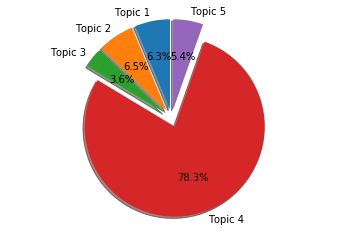

In [20]:
labels = lambda_df.columns[1:]
sizes = prob_topics*100
explode = (0.1, 0.1, 0.1,0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Aditional tasks

Try to reproduce Figure 2 in the Case study 1.1.2 guide, where the distribution of topics across labs is shown.
